In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt

In [2]:
N = 10000
n = 1.31

In [3]:
def get_sun_ray(h):
    sun_height = np.radians(h)
    r = np.array([-1 * np.cos(sun_height), 0, -1 * np.sin(sun_height)])
    return r

In [4]:
def get_first_face(n, h):
    r = get_sun_ray(h)
    s = np.stack([np.random.normal(0,1,N), np.random.normal(0,1,N), np.random.normal(0,1,N)], axis=1)
    s = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 1, s)
    s = s[np.apply_along_axis(lambda x: np.dot(x, r) >= 0, 1, s)]
    return s

In [5]:
def get_second_face(s_, f_):
    n = len(s_) // 2
    sr_1 = np.apply_along_axis(lambda x: f_(x, 60), 1, s_[:n])
    sr_2 = np.apply_along_axis(lambda x: f_(x, -60), 1, s_[n:])
    sr = np.concatenate((sr_1, sr_2))
    return sr

In [6]:
def rot(s_, r_, angle_):
    z = r_ / np.linalg.norm(r_)
    cross = np.cross(s_, z)
    dot = np.dot(s_, z)
    rot_angle = np.radians(angle_)
    cross_normed = cross / np.linalg.norm(cross)
    assert np.abs(np.linalg.norm(cross_normed) - 1) < 0.001
    rot_m = R.from_rotvec(rot_angle * cross_normed).as_matrix()
    return np.matmul(s_, rot_m)

In [7]:
def tangent_arc(s_):
    z = np.array([0,0,1])
    f = lambda x, a: rot(x, z, a)
    return get_second_face(s_, f)

In [8]:
def halo_22(s_):
    f = lambda x, a: rot(x, np.random.normal(size=3), a)
    return get_second_face(s_, f)

In [9]:
def refract(r_, s_, n_):
    cos_a = np.dot(s_, r_) # cos(alpha)
    sin_a = np.linalg.norm(np.cross(s_, r_)) # sin(alpha)
    assert sin_a >= 0
    assert np.abs(cos_a**2 + sin_a**2 - 1) < 0.001
    sin_b = sin_a / n_
    if np.abs(sin_b) > 1:
        return 0
    r_s = s_ * cos_a
    l = (r_ - r_s) / np.linalg.norm(r_ - r_s)
    rr_l = l * sin_b
    rr_s = s_ * np.cos(np.arcsin(sin_b))
    return rr_l + rr_s

In [10]:
def get_output_paths(h, S_, SR_):
    r = get_sun_ray(h)
    rr = np.apply_along_axis(lambda s_: refract(r, s_, n), 1, S_)
    rrr = np.empty_like(rr)
    for i, (r_, sr_) in enumerate(zip(rr, SR_)):
        rrr[i] = refract(r_, sr_, 1 / n)
    not_zerors = np.apply_along_axis(lambda x: np.linalg.norm(x) > 0.01, 1, rrr)
    rrr = rrr[not_zerors]
    return rrr

In [11]:
def get_data(N, h):
    s = get_first_face(N, h)
    sr = tangent_arc(s)
    data = get_output_paths(h, s, sr)
    print(len(data))
    return data

In [12]:
h = [0, 15, 30, 45]
data = [get_data(N, h_) for h_ in h]

1012
1036
1653
2066


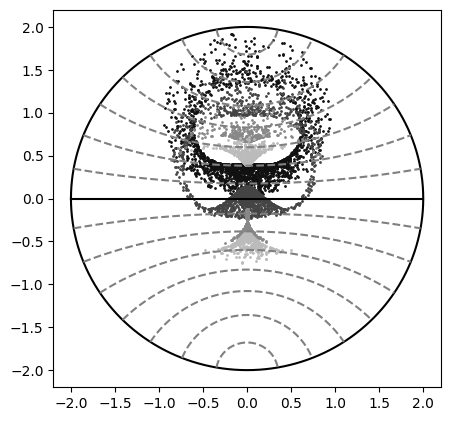

In [13]:
def get_stereographic(x):
    R = 1
    r0 = np.array([-1,0,0])
    s = x + r0
    n = np.dot(s, r0) * r0
    k = 2 / np.linalg.norm(n)
    r = k * (s - n)
    z0 = np.array([0,0,1])
    y_ = -np.dot(r, z0)
    cross = np.cross(r, z0)
    x_ = np.linalg.norm(cross) * np.sign(np.dot(cross, r0))
    return np.array([x_, y_])


b = np.array([ np.array([0, np.cos(np.radians(i)), np.sin(np.radians(i))]) for i in range(361)])

def parallel(h):
    h_ = np.radians(h)
    return np.array([ np.array([ \
                         np.cos(np.radians(i)) * np.cos(h_), \
                         np.sin(np.radians(i)) * np.cos(h_), \
                         np.sin(h_)]) for i in np.linspace(90, 270, 100)])


plt.figure(dpi=100,figsize=(5,5))

d = np.apply_along_axis(get_stereographic, 1, data[3])
plt.plot(d[:, 0], d[:, 1], 'o', color='#111111', markersize=1)

d = np.apply_along_axis(get_stereographic, 1, data[2])
plt.plot(d[:, 0], d[:, 1], 'o', color='#444444', markersize=1)

d = np.apply_along_axis(get_stereographic, 1, data[1])
plt.plot(d[:, 0], d[:, 1], 'o', color='#888888', markersize=1)

d = np.apply_along_axis(get_stereographic, 1, data[0])
plt.plot(d[:, 0], d[:, 1], 'o', color='#BBBBBB', markersize=1)


d = np.apply_along_axis(get_stereographic, 1, b)
plt.plot(d[:, 0], d[:, 1], markersize=1, color='black')

for i in np.linspace(10, 80, 7):
    d = np.apply_along_axis(get_stereographic, 1, parallel(i))
    plt.plot(d[:, 0], d[:, 1], markersize=0.5, color='gray', linestyle='dashed')
    d = np.apply_along_axis(get_stereographic, 1, parallel(-i))
    plt.plot(d[:, 0], d[:, 1], markersize=0.5, color='gray', linestyle='dashed')

d = np.apply_along_axis(get_stereographic, 1, parallel(0))
plt.plot(d[:, 0], d[:, 1], markersize=0.5, color='black')

plt.show()
    


In [14]:
for i in range(len(data)):
    with open('../data/tanget_arc_h' + str(i * 15) + '.csv', 'w') as f:
        f.write('x,y\n')
        d_ = np.apply_along_axis(get_stereographic, 1, data[i])
        for d in d_:
            f.write('{:.3f},{:.3f}\n'.format(d[0], d[1]))

In [15]:
with open('../data/tanget_arc_grid_border.csv'.format(h), 'w') as f:
        data = np.apply_along_axis(get_stereographic, 1, b)
        f.write('x,y\n')
        for d in data:
            f.write('{:.3f},{:.3f}\n'.format(d[0], d[1]))

In [17]:
heights = np.linspace(-80, 80, 17)
for h in heights:
    with open('../data/tanget_arc_grid{:.0f}.csv'.format(h), 'w') as f:
        data = np.apply_along_axis(get_stereographic, 1, parallel(h))
        f.write('x,y\n')
        for d in data:
            f.write('{:.3f},{:.3f}\n'.format(d[0], d[1]))